In [1]:
import os
import tarfile
from urllib.request import urlretrieve

def download_file(url, path):
    print("Downloading from %s" % url)
    zip_path = path + ".zip"
    urlretrieve(url, zip_path)
    tar = tarfile.open(zip_path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(zip_path)    

In [3]:
download_file("https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz", "notMNIST_large")
download_file("https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz", "notMNIST_small")

In [2]:
large_mnist = "notMNIST_large"
small_mnist = "notMNIST_small"

In [3]:
import imageio

def load_data(folder):
    available_classes = os.listdir(folder)
    data = []
    for img_class in available_classes:
        images = os.listdir(folder + '/' + img_class)
        for image in images:
            path = folder + '/' + img_class + '/' + image
            try:
                img = imageio.imread(path)
            except Exception as e:
                print(e)
                continue
            data.append((img.flatten() / 255., available_classes.index(img_class)))
    return data, available_classes

In [4]:
data, available_classes = load_data(small_mnist)

Could not find a format to read the specified file in mode 'i'
Could not find a format to read the specified file in mode 'i'


In [5]:
len(data)

18724

In [6]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img = random.choice(data)[0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.reshape(28, 28), interpolation='nearest', cmap='Greys')

plt.show()

<Figure size 800x800 with 20 Axes>

In [7]:
from collections import Counter

classes = [d[1] for d in data]
counts = Counter(classes)
print(counts)

Counter({0: 1873, 6: 1873, 7: 1873, 9: 1873, 1: 1872, 2: 1872, 3: 1872, 4: 1872, 5: 1872, 8: 1872})


In [8]:
#train_size = 500000
#val_size = 10000

train_size = 16000
val_size = 1000

random.shuffle(data)
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

In [27]:
def remove_duplicates(train, val, test):
    index = {}
    for img, cls in val + test:
        if cls not in index:
            index[cls] = {}

        val_h = sum(img)
        if val_h not in index[cls]:
            index[cls][val_h] = []
        index[cls][val_h].append(img)
        
    duplicate_ids = []
    for i, img_cls in enumerate(train):
        img, cls = img_cls
        img = list(img)
        h = sum(img)
        if h in index[cls]:
            candidates = index[cls][h]
            for candidate in candidates:
                if list(candidate) == img:
                    duplicate_ids.append(i)
                    break
                
    for data_id in reversed(duplicate_ids):
        del train[data_id]

In [14]:
import numpy as np

def unzip(tuples):
    first = [t[0] for t in tuples]
    second = [t[1] for t in tuples]
    return np.array(first), second

In [15]:
train_x, train_y = unzip(train_data)
val_x, val_y = unzip(val_data)
test_x, test_y = unzip(test_data)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing

clf = OneVsRestClassifier(LogisticRegression(verbose=1, max_iter=1000))
clf.fit(train_x, train_y)
clf.score(test_x, test_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=1, warm_start=False),
                    n_jobs=None)

In [24]:
for c in [1, 10, 100, 1000]:
    clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, C=c))
    clf.fit(train_x, train_y)
    score = clf.score(val_x, val_y)
    print("C = %d, score = %f" % (c, score))

C = 1, score = 0.889000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

C = 10, score = 0.860000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

C = 100, score = 0.840000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

C = 1000, score = 0.824000


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train size = 1000, score = 0.843387
Train size = 2000, score = 0.850348
Train size = 4000, score = 0.864269
Train size = 8000, score = 0.866589
Train size = 16000, score = 0.879350


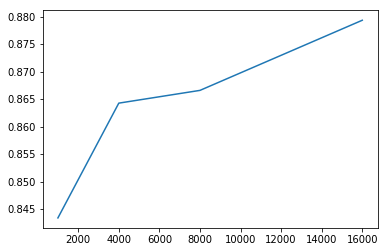

In [26]:
scores = []
train_sizes = [1000, 2000, 4000, 8000, 16000]
for train_size in train_sizes:
    sub_train_x = train_x[:train_size]
    sub_train_y = train_y[:train_size]

    clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    clf.fit(sub_train_x, sub_train_y)
    score = clf.score(test_x, test_y)
    scores.append(score)
    print("Train size = %d, score = %f" % (train_size, score))
    
plt.plot(train_sizes, scores)
plt.show()